In [7]:
#importing important modules
import sys
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#importing causalnex modules
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

In [5]:
#modeling modules
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [10]:
#importing the local modules
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from outlier import Outlier
from overview import Overview
from pre_process import Process
import visualization as viz

In [11]:
#creating processing object
process = Process()

## Reading Data

In [13]:
# reading the csv file
df = pd.read_csv("../data/data_cleaner.csv")
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,...,25.38,17.33,184.60,1937.05,0.1622,0.62695,0.7119,0.2654,0.41915,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1937.05,0.1238,0.18660,0.2416,0.1860,0.27500,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.00,0.1444,0.42450,0.4504,0.2430,0.36130,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,...,14.91,26.50,98.87,567.70,0.1901,0.62695,0.6869,0.2575,0.41915,0.12301
4,84358402,M,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.00,0.1374,0.20500,0.4000,0.1625,0.23640,0.07678


In [14]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [23]:
features= ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean','area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean','concave points_mean', 'symmetry_mean', 'fractal_dimension_mean','radius_se', 'texture_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst','perimeter_worst', 'area_worst', 'smoothness_worst','compactness_worst', 'concavity_worst', 'concave points_worst','symmetry_worst', 'fractal_dimension_worst']

In [24]:
#encoding the diagnosis categories 
x = df[features[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,...,25.38,17.33,184.60,1937.05,0.1622,0.62695,0.7119,0.2654,0.41915,0.11890
1,1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1937.05,0.1238,0.18660,0.2416,0.1860,0.27500,0.08902
2,1,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.00,0.1444,0.42450,0.4504,0.2430,0.36130,0.08758
3,1,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,...,14.91,26.50,98.87,567.70,0.1901,0.62695,0.6869,0.2575,0.41915,0.12301
4,1,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.00,0.1374,0.20500,0.4000,0.1625,0.23640,0.07678


# Normalizing

In [27]:
features = x.iloc[:, 1:]
features

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890
1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902
2,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758
3,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,0.07875,...,14.910,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301
4,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115
565,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637
566,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820
567,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301


In [34]:
normal_data = process.scale_and_normalize(features, features.columns.to_list())
normal_data.insert(loc=0, column='diagnosis', value=x['diagnosis'])
normal_data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,0.164613,0.007278,0.169957,0.161726,0.178017,0.223078,0.223078,0.212345,0.215653,...,0.199319,0.038635,0.218622,0.223078,0.170154,0.223078,0.202176,0.203453,0.223078,0.209589
1,1,0.301190,0.129788,0.284132,0.330585,0.116883,0.093651,0.101750,0.150147,0.171204,...,0.288849,0.122841,0.261758,0.330669,0.144246,0.087848,0.101705,0.211355,0.149188,0.165310
2,1,0.228169,0.150521,0.222660,0.239924,0.182614,0.179878,0.187220,0.221681,0.189592,...,0.214496,0.118023,0.199703,0.232979,0.163759,0.177419,0.153581,0.223665,0.208851,0.128229
3,1,0.075487,0.131824,0.082663,0.052036,0.253702,0.253702,0.216861,0.172708,0.253702,...,0.090673,0.119818,0.089789,0.055393,0.253702,0.253702,0.221856,0.224496,0.253702,0.253702
4,1,0.262567,0.066362,0.259151,0.287039,0.164521,0.159543,0.206357,0.198651,0.151736,...,0.220182,0.044639,0.218805,0.233501,0.162432,0.087225,0.149881,0.164359,0.089537,0.094140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,0.253959,0.160473,0.246112,0.259882,0.181990,0.119881,0.224444,0.233589,0.118023,...,0.233135,0.121889,0.219578,0.259882,0.151377,0.079747,0.135880,0.197903,0.048978,0.061596
565,1,0.248915,0.254984,0.238045,0.266830,0.148540,0.113406,0.144006,0.178936,0.133691,...,0.227904,0.241615,0.215727,0.249203,0.105908,0.077668,0.115593,0.158001,0.108280,0.047077
566,1,0.241229,0.334699,0.232738,0.226043,0.131311,0.148270,0.122560,0.128367,0.132279,...,0.211690,0.269687,0.208461,0.200501,0.131714,0.176016,0.162090,0.182315,0.093020,0.127486
567,1,0.190242,0.199116,0.193541,0.197601,0.164655,0.208402,0.208402,0.204983,0.198074,...,0.190048,0.186243,0.204239,0.194596,0.163922,0.208402,0.208402,0.189782,0.200110,0.208402


In [44]:
#the graph structure describing conditional dependencies between features 0-9 with diagnosis
%%time #measuring system time
sm = from_pandas(normal_data.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

UsageError: Line magic function `%%time` not found.


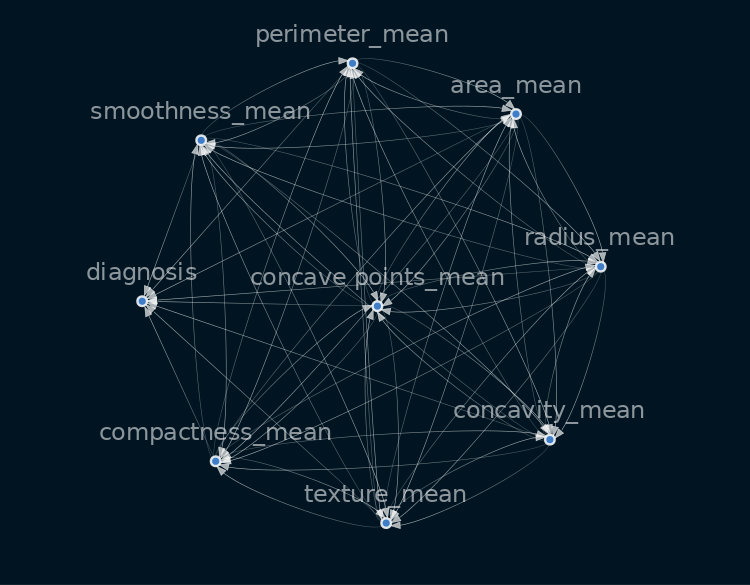

In [46]:
viz.vis_sm(sm)

In [ ]:
# removing features whose absolute weights are less than a defined threshold i.e.
